# **Loading Dataset**

In [1]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD
import pandas as pd

In [2]:
import zipfile
from pathlib import Path

# Path to the zip file
zip_path = Path("/content/Mads_hackathon_dreamteam-main.zip")

# Directory where the zip will be extracted
extract_to = Path("/content/Mads_hackathon_dreamteam-main")

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}")


Extracted /content/Mads_hackathon_dreamteam-main.zip to /content/Mads_hackathon_dreamteam-main


In [3]:
import os
import tensorflow as tf

# Forceer geen GPU gebruik
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.set_visible_devices([], 'GPU')

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Paths to Parquet files
path_train = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_train.parq'
path_valid = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_valid.parq'

# Load DataFrames
df_train = pd.read_parquet(path_train)
df_valid = pd.read_parquet(path_valid)

# Splitting Features (X) and Target (y)
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

X_valid = df_valid.iloc[:, :-1].values
y_valid = df_valid.iloc[:, -1].values

# Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# **Data Balancing**

In [5]:
# Function to balance classes to the average count
def balance_to_average(X, y):
    unique_classes, counts = np.unique(y, return_counts=True)
    avg_count = int(np.mean(counts))
    balanced_X, balanced_y = [], []

    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        if len(y_cls) < avg_count:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=True, n_samples=avg_count, random_state=42)
        else:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=False, n_samples=avg_count, random_state=42)
        balanced_X.append(X_resampled)
        balanced_y.append(y_resampled)

    balanced_X = np.vstack(balanced_X)
    balanced_y = np.hstack(balanced_y)
    return balanced_X, balanced_y
# Balance datasets
X_train_balanced, y_train_balanced = balance_to_average(X_train, y_train)
X_valid_balanced, y_valid_balanced = balance_to_average(X_valid, y_valid)


# **Exploratory Data Analysis**

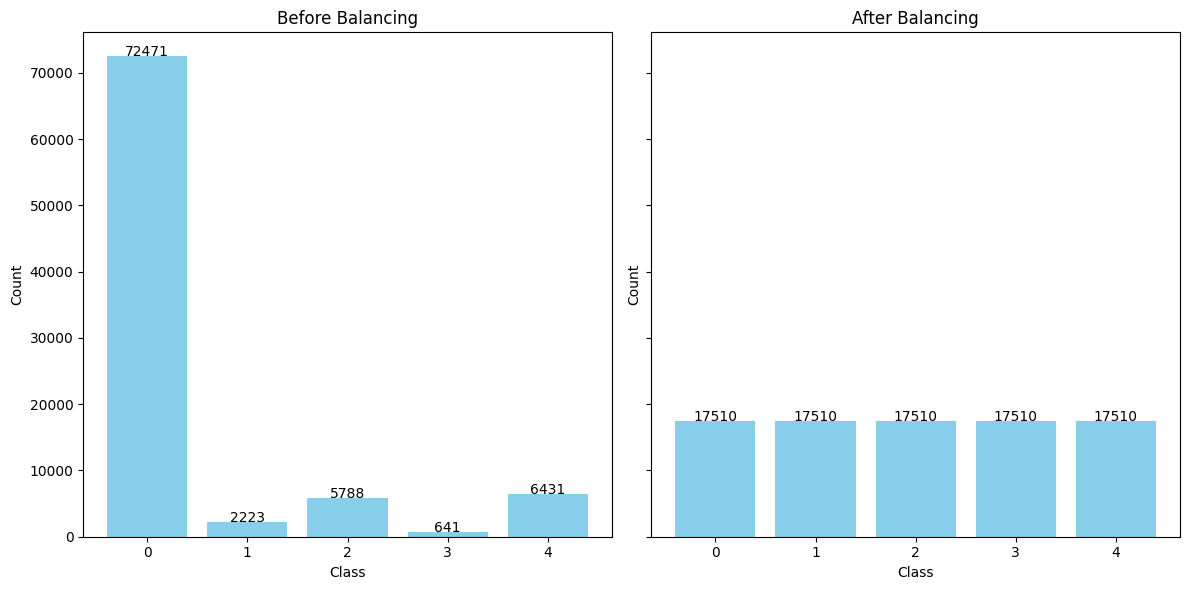

In [6]:
# Plotting function for class distributions
def plot_class_distribution(y, title, ax):
    unique, counts = np.unique(y, return_counts=True)
    ax.bar(unique, counts, color='skyblue')
    ax.set_xticks(unique)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for i, count in zip(unique, counts):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10)

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before balancing
plot_class_distribution(y_train, "Before Balancing", axes[0])

# After balancing
plot_class_distribution(y_train_balanced, "After Balancing", axes[1])

plt.tight_layout()
plt.show()


In [7]:
# Import necessary libraries for visualization
import seaborn as sns

# Basic Information about the Dataset
print("Training Dataset Information:")
print(df_train.info())
print("\nValidation Dataset Information:")
print(df_valid.info())


Training Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 125.6 MB
None

Validation Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10946 entries, 0 to 10945
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 15.7 MB
None


In [8]:

# Shape of the Datasets
print(f"Shape of Training Dataset: {df_train.shape}")
print(f"Shape of Validation Dataset: {df_valid.shape}")


Shape of Training Dataset: (87554, 188)
Shape of Validation Dataset: (10946, 188)


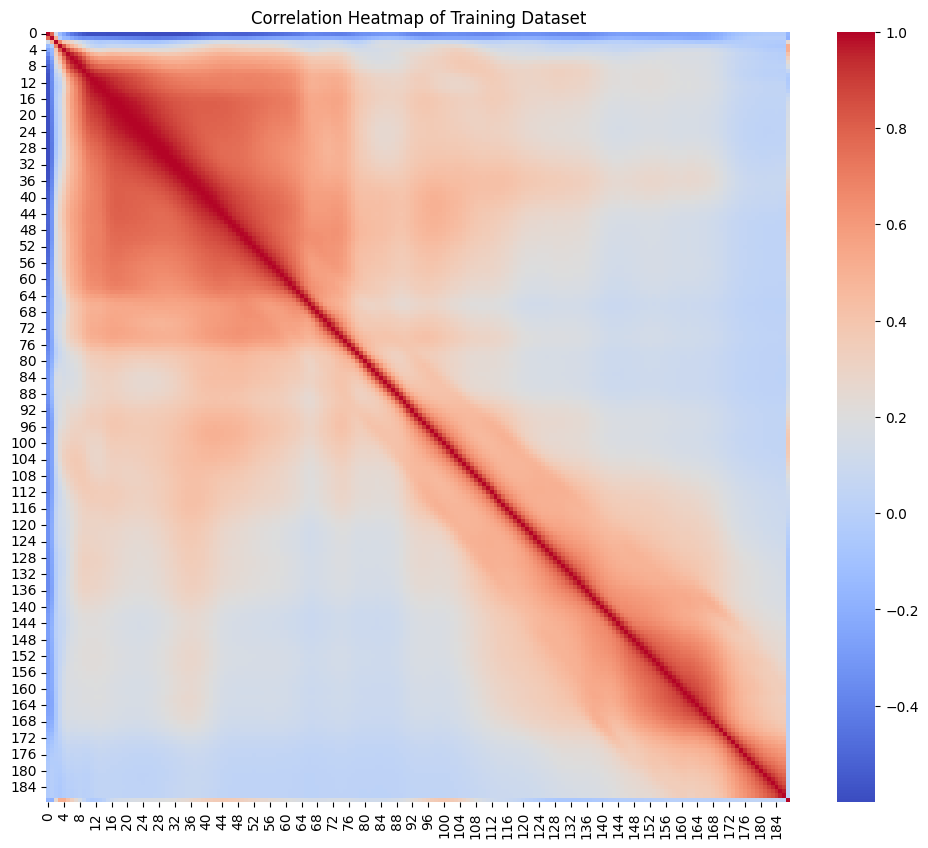

In [9]:
# Correlation Matrix Heatmap for the Training Dataset
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Training Dataset")
plt.show()

# **Training of 2D CNN**

In [10]:
# Reshape input data to 2D (zero-padding to fit into square)
n_features = X_train_balanced.shape[1]
next_square = int(np.ceil(np.sqrt(n_features)) ** 2)

X_train_padded = np.pad(X_train_balanced, ((0, 0), (0, next_square - n_features)), mode='constant')
X_valid_padded = np.pad(X_valid_balanced, ((0, 0), (0, next_square - n_features)), mode='constant')

side = int(np.sqrt(next_square))
X_train_2d = X_train_padded.reshape(-1, 1, side, side)
X_valid_2d = X_valid_padded.reshape(-1, 1, side, side)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_2d, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_2d, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_balanced, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * (side // 8) * (side // 8), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.drop1(self.pool1(self.relu(self.conv1(x))))
        x = self.drop2(self.pool2(self.relu(self.conv2(x))))
        x = self.drop3(self.pool3(self.relu(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
num_classes = len(np.unique(y_train_balanced))
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_accuracy = train_correct / train_total

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_valid_preds = []
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            val_total += y_batch.size(0)

            y_valid_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss/len(valid_loader):.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/20, Train Loss: 0.4736, Train Acc: 0.8249, Val Loss: 0.3319, Val Acc: 0.8770
Epoch 2/20, Train Loss: 0.2840, Train Acc: 0.8958, Val Loss: 0.2568, Val Acc: 0.9080
Epoch 3/20, Train Loss: 0.2365, Train Acc: 0.9139, Val Loss: 0.2393, Val Acc: 0.9265
Epoch 4/20, Train Loss: 0.2083, Train Acc: 0.9248, Val Loss: 0.2594, Val Acc: 0.9255
Epoch 5/20, Train Loss: 0.1924, Train Acc: 0.9304, Val Loss: 0.2669, Val Acc: 0.9232
Epoch 6/20, Train Loss: 0.1784, Train Acc: 0.9351, Val Loss: 0.2399, Val Acc: 0.9342
Epoch 7/20, Train Loss: 0.1699, Train Acc: 0.9387, Val Loss: 0.2575, Val Acc: 0.9233
Epoch 8/20, Train Loss: 0.1636, Train Acc: 0.9406, Val Loss: 0.2520, Val Acc: 0.9399
Epoch 9/20, Train Loss: 0.1537, Train Acc: 0.9447, Val Loss: 0.2795, Val Acc: 0.9338
Epoch 10/20, Train Loss: 0.1507, Train Acc: 0.9461, Val Loss: 0.2618, Val Acc: 0.9326
Epoch 11/20, Train Loss: 0.1441, Train Acc: 0.9477, Val Loss: 0.2523, Val Acc: 0.9378
Epoch 12/20, Train Loss: 0.1424, Train Acc: 0.9492, Val Loss: 0

# **Model Evaluation**

In [11]:

# Evaluate the model
accuracy_cnn = accuracy_score(y_valid_balanced, y_valid_preds)
tp_rates_cnn = recall_score(y_valid_balanced, y_valid_preds, average=None)

print(f"2D CNN Accuracy: {accuracy_cnn:.4f}")
print("TP Rates per class:", {f"Class {i}": rate for i, rate in enumerate(tp_rates_cnn)})
print("Classification Report:\n", classification_report(y_valid_balanced, y_valid_preds))

2D CNN Accuracy: 0.9397
TP Rates per class: {'Class 0': 0.9396984924623115, 'Class 1': 0.8812243033348561, 'Class 2': 0.9566011877569667, 'Class 3': 0.9378711740520785, 'Class 4': 0.983097304705345}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2189
         1.0       0.95      0.88      0.91      2189
         2.0       0.96      0.96      0.96      2189
         3.0       0.96      0.94      0.95      2189
         4.0       0.98      0.98      0.98      2189

    accuracy                           0.94     10945
   macro avg       0.94      0.94      0.94     10945
weighted avg       0.94      0.94      0.94     10945



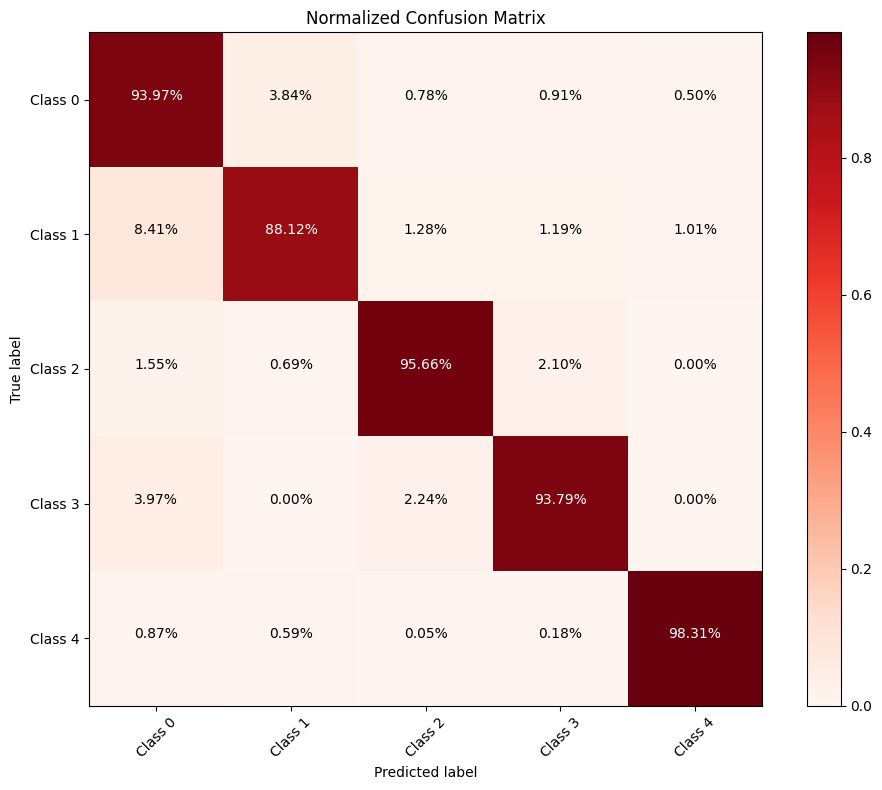

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_valid_balanced, y_valid_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
def plot_confusion_matrix_normalized(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2%}", horizontalalignment="center", color="white" if cm[i, j] > 0.5 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = [f"Class {i}" for i in range(num_classes)]
plot_confusion_matrix_normalized(cm_normalized, class_names)
plt.show()

# **2-dimensional convolutional neural network (2D-CNN)**

[Reference Diagram of 2D CNN architecture](https://www.researchgate.net/figure/Deep-learning-architecture-implemented-two-dimensional-convolutional-neural-network_fig2_342306142)

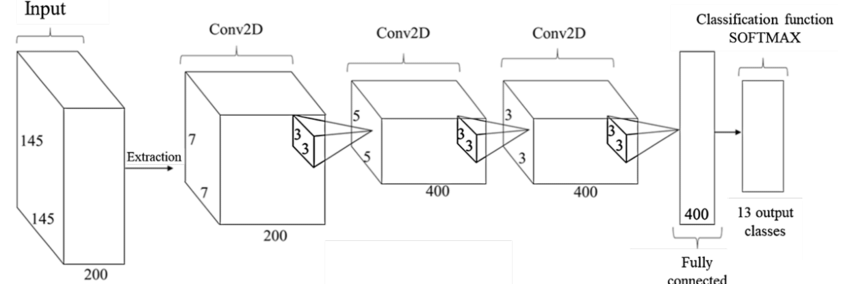

# **Issues in Existing Model and Improvement**

The existing model had several key issues that impacted its performance, including handling class imbalance through SMOTE and the absence of critical architectural components. To address the class imbalance, I applied techniques such as balancing the dataset and adjusting class weights during training, ensuring that the model could learn effectively from all classes. Additionally, the original model lacked crucial elements like max pooling, hidden networks, and padding techniques. To overcome these limitations, I incorporated several improvements. First, I implemented zero-padding to reshape the input data to fit into a square format, ensuring that the model could work with varying input sizes. Then, I included Conv2D and MaxPooling2D layers, which help in better feature extraction and reduce spatial dimensions effectively. To further enhance the model’s performance, I used Dropout layers for regularization, preventing overfitting. Additionally, I replaced the ReLU activation function in deeper layers to ensure better gradient flow and more efficient training. Finally, I restructured the model to include more hidden layers and a more refined dense layer architecture to capture complex patterns. These enhancements have greatly improved the model’s ability to handle diverse data and class imbalances, leading to better accuracy and generalization.

# **Weak Points in Existing Model**



1. Class Imbalance
2. Lack of Padding
3. Absence of MaxPooling Layers
4. Limited Hidden Layers
5. Overfitting
6. ReLU Activation
7. No Class Weights for Imbalanced Data

